# Inference Service

* Create an inference service to serve one of the registered models
* Fetch online features and calculate predictions from the inference service

**Prerequisites**
* Create a `Model Server`called `mnist` under the current workspace `feast`

## Imports and constants

In [1]:
!pip install -q --upgrade pip
!pip install -q --no-deps --ignore-requires-python "https://github.com/opendatahub-io/ml-metadata/releases/download/v1.14.0%2Bremote.1/ml_metadata-1.14.0+remote.1-py3-none-any.whl" # need a Python 3.11 compatible version
!pip install -q --no-deps --ignore-requires-python "model-registry==0.1.2" # ignore dependencies because of the above override
!pip uninstall -q ray --yes
!pip install -q "ray[serve]<=2.9.3,>=2.9.2"
!pip install -q kserve[storage]>=0.12.0
!pip install -q -r requirements.txt
!pip list | grep ray

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
codeflare-sdk 0.14.1 requires pydantic<2, but you have pydantic 2.7.1 which is incompatible.
codeflare-sdk 0.14.1 requires ray[data,default]==2.7.0, but you have ray 2.9.3 which is incompatible.
codeflare-sdk 0.14.1 requires rich<13.0,>=12.5, but you have rich 13.7.1 which is incompatible.
kserve 0.12.1 requires fastapi<0.110.0,>=0.109.1, but you have fastapi 0.108.0 which is incompatible.
kserve 0.12.1 requires protobuf<4.0.0,>=3.19.0, but you have protobuf 4.23.3 which is incompatible.
kserve 0.12.1 requires ray[serve]<3.0.0,>=2.10.0, but you have ray 2.9.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
codeflare-sdk 0.14.1 requires pydantic<2, but you have pydant

In [2]:
# See https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

from src import s3
from src.kserve import utils as kserve
from src.feast import utils as feast
from src.model_registry import utils as model_registry

from kserve import KServeClient

# help(kserve)
# help(feast)
# help(model_registry)

Initialized MinIO S3 environment served by http://minio-service.feast.svc.cluster.local:9000


/opt/app-root/lib64/python3.9/site-packages/pydantic/_internal/_config.py:334: UserWarning: Valid config keys have changed in V2:
* 'json_loads' has been removed
  warnings.warn(message, UserWarning)
/opt/app-root/lib64/python3.9/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_version" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Initialized Feast environment for repo mnist_demo/feature_repo/


## Selecting one of the registered models

Update the logic defined in [src/model_registry/utils.py](./src/model_registry/utils.py) to select a different model and version

In [3]:
help(model_registry.select_model_for_test)

Help on function select_model_for_test in module src.model_registry.utils:

select_model_for_test()
    Select the first model, version and artifact available from the ModelRegistry (excluding
    the ARCHIVED versions).
    Returns the tuple (selected_model, selected_model_version, selected_model_artifact)



In [4]:
selected_model, selected_model_version, selected_model_artifact = model_registry.select_model_for_test()
print('=' * 30)
print(f"Creating inference service for model: {selected_model.id}\n{selected_model}")
print('=' * 30)
print(f"Creating inference service for model version: {selected_model_version.id}\n{selected_model_version}")
print('=' * 30)
print(f"Creating inference service for model artifact: {selected_model_artifact.id}\n{selected_model_artifact}")

INFO:absl:MetadataStore with gRPC connection initialized


Model mnist
Version v.simple_NN.20240419150600
Artifact mnist: s3://feast/v.simple_NN.20240419150600/simple_NN.onnx?endpoint=http://minio-service.feast.svc.cluster.local:9000&defaultRegion=default
Version v.convolutedNN.202404191508261
Artifact mnist: s3://feast/v.convolutedNN.20240419150826/convolutedNN.onnx?endpoint=http://minio-service.feast.svc.cluster.local:9000&defaultRegion=default
Version v.simple_NN.20240424124319
Artifact mnist: s3://feast/v.simple_NN.20240424124319/simple_NN.onnx?endpoint=http://minio-service.feast.svc.cluster.local:9000&defaultRegion=default
Version v.convolutedNN.202404241246291
Artifact mnist: s3://feast/v.convolutedNN.20240424124629/convolutedNN.onnx?endpoint=http://minio-service.feast.svc.cluster.local:9000&defaultRegion=default
Version v.simple_NN.20240424142816
Artifact mnist: s3://feast/v.simple_NN.20240424142816/simple_NN.onnx?endpoint=http://minio-service.feast.svc.cluster.local:9000&defaultRegion=default
Version v.simple_NN.202404241428161
Artifac

## Create the Inference Service

Referenced functions: [./src/kserve/utils.py](./src/kserve/utils.py)

Fetch the existing services using `oc` CLI

In [5]:
!oc get inferenceservices -n $MODEL_NAMESPACE 

No resources found in feast namespace.


Create a `Data Connection` to the S3 bucket.

The `Data Connection` is defined by a `Secret` with well-defined annotations, labels and keys to match the KServe definition.

In [6]:
kserve.create_data_connection_secret(selected_model)

In [7]:
!cat connection_secret.yaml


kind: Secret
apiVersion: v1
metadata:
  name: mnist-s3-creds
  namespace: feast
  labels:
    opendatahub.io/dashboard: 'true'
    opendatahub.io/managed: 'true'
  annotations:
    opendatahub.io/connection-type: s3
    openshift.io/display-name: mnist-s3
stringData:
  AWS_ACCESS_KEY_ID: minio
  AWS_DEFAULT_REGION: default
  AWS_S3_BUCKET: feast
  AWS_S3_ENDPOINT: http://minio-service.feast.svc.cluster.local:9000
  AWS_SECRET_ACCESS_KEY: minio123
type: Opaque


In [8]:
!oc delete -f connection_secret.yaml
!oc create -f connection_secret.yaml

Error from server (NotFound): error when deleting "connection_secret.yaml": secrets "mnist-s3-creds" not found
secret/mnist-s3-creds created


Create the `InferenceService` resource (see [Create the InferenceService](https://kserve.github.io/website/master/modelserving/v1beta1/onnx/#create-the-inferenceservice))

In [9]:
inference_service = kserve.create_inference_service(selected_model, selected_model_version, selected_model_artifact)

Creating InferenceService simple-nn to serve s3://feast/v.simple_NN.20240424155139/simple_NN.onnx


Delete the existing instance with same name

In [10]:
KServe = KServeClient()
kserve.delete_existing_inference_service(KServe, inference_service)

No existing service to delete


/opt/app-root/lib64/python3.9/site-packages/kubernetes/client/rest.py:44: DeprecationWarning: HTTPResponse.getheaders() is deprecated and will be removed in urllib3 v2.1.0. Instead access HTTPResponse.headers directly.
  return self.urllib3_response.getheaders()


Deploying the InferenceService with the `KServeClient`

In [11]:
created_inference_service = KServe.create(inference_service)

In [12]:
kserve.wait_until_predictor_is_ready(KServe, inference_service)

Waiting until model simple-nn is ready
Predictor is ready for simple-nn


## Inspecting the Inference Service

Verify resources using `oc` CLI

In [16]:
!oc get inferenceservices -n $MODEL_NAMESPACE $MODEL_NAME
!oc get routes -n $MODEL_NAMESPACE $MODEL_NAME

NAME        URL                                   READY   PREV   LATEST   PREVROLLEDOUTREVISION   LATESTREADYREVISION   AGE
simple-nn   grpc://modelmesh-serving.feast:8033   True                                                                  23s
NAME        HOST/PORT                                                  PATH                   SERVICES            PORT   TERMINATION          WILDCARD
simple-nn   simple-nn-feast.apps.feast-lab.4cuu.p1.openshiftapps.com   /v2/models/simple-nn   modelmesh-serving   8443   reencrypt/Redirect   None


Fetch model URIs

In [17]:
rest_uri, model_service_uri, prediction_uri = kserve.inference_service_uris(KServe, inference_service)
print(f"REST URI for model {inference_service.metadata.name} is {rest_uri}")
print(f"Model service URI for model {inference_service.metadata.name} is {model_service_uri}")
print(f"Prediction URI for model {inference_service.metadata.name} is {prediction_uri}")

REST URI for model simple-nn is http://modelmesh-serving.feast:8008
Model service URI for model simple-nn is http://modelmesh-serving.feast:8008/v2/models/simple-nn
Prediction URI for model simple-nn is http://modelmesh-serving.feast:8008/v2/models/simple-nn/infer


Inspect service metedata

In [18]:
kserve.inspect_service_metadata(model_service_uri)

Metadata request to http://modelmesh-serving.feast:8008/v2/models/simple-nn succeded.


{'name': 'simple-nn__isvc-15d0e1513d',
 'versions': ['1'],
 'platform': 'OpenVINO',
 'inputs': [{'name': 'x', 'datatype': 'FP64', 'shape': ['1', '28', '28']}],
 'outputs': [{'name': 'dense_2', 'datatype': 'FP32', 'shape': ['1', '10']}]}

## Validating online features

Fetching online features from `Feast`.

See [./src/feast/utils.py](./src/feast/utils.py)

In [19]:
online_features = feast.fetch_online_features()

INFO:feast.infra.registry.registry:Registry cache expired, so refreshing


In [20]:
assert len(online_features) == 10, f"Found {len(online_features)} instead of 10"

In [21]:
online_features.head()

,image_id,feature_12,feature_24,feature_26,feature_28,feature_13,feature_23,feature_9,feature_5,feature_20,...,feature_11,feature_7,feature_8,feature_3,feature_4,feature_1,feature_27,feature_16,feature_22,feature_10
8,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8367347121238...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
0,0,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.1428571492433548, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0

For each online feature, invokes the prediction service and plot the image for visual verification

The predicted number for image 8 is 3


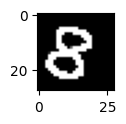

The prediction failed: expected 8, predicted 3
The predicted number for image 1 is 4


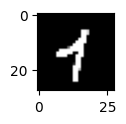

The prediction failed: expected 1, predicted 4
The predicted number for image 5 is 9


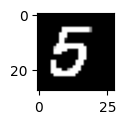

The prediction failed: expected 5, predicted 9
The predicted number for image 0 is 5


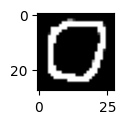

The prediction failed: expected 0, predicted 5
The predicted number for image 7 is 7


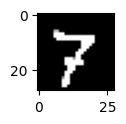

The predicted number for image 2 is 3


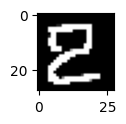

The prediction failed: expected 2, predicted 3
The predicted number for image 9 is 9


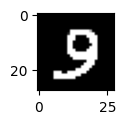

The predicted number for image 4 is 6


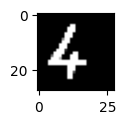

The prediction failed: expected 4, predicted 6
The predicted number for image 3 is 3


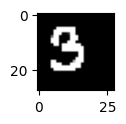

The predicted number for image 6 is 2


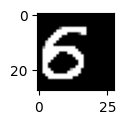

The prediction failed: expected 6, predicted 2


In [22]:
image_ids, images = feast.to_model_data(online_features)
for i in range(len(image_ids)):
    image_id = image_ids[i]
    image = images[i]
    try:
        kserve.validate_prediction(inference_service, prediction_uri, image_id, image)
    except Exception as e:
        print(str(e))